# Классификация одежды.

Необходимо построить модель, которая по фотографии определит тип предмета гардероба. В нашем распоряжении набор фотографий вещей из датасета [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Последовательность решения задачи:
1. Анализ данных;
2. Подготовка данных;
3. Создание модели и её обучение;
4. Вывод и оценка качества модели.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
PATH = '/kaggle/input/fashionmnist/'

## Анализ данных

Загрузим и проанализируем данные.

In [3]:
# Загрузка данных
df_train = pd.read_csv(PATH + 'fashion-mnist_train.csv')
df_test = pd.read_csv(PATH + 'fashion-mnist_test.csv')

In [4]:
def data_info(df):
    """Изучение датасета"""
    display(df.head())
    display(df.info())
    # Проверка дизбаланса классов
    df['label'].hist()
    print('Количество дубликатов =', df.duplicated().sum())
    

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


None

Количество дубликатов = 43


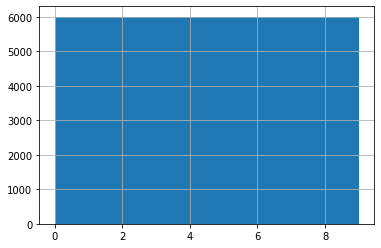

In [5]:
# Анализ трениоровочных данных
data_info(df_train)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


None

Количество дубликатов = 1


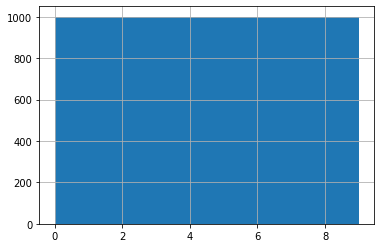

In [6]:
# Анализ тестовых данных
data_info(df_test)

In [7]:
# Надвания классов вещей
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

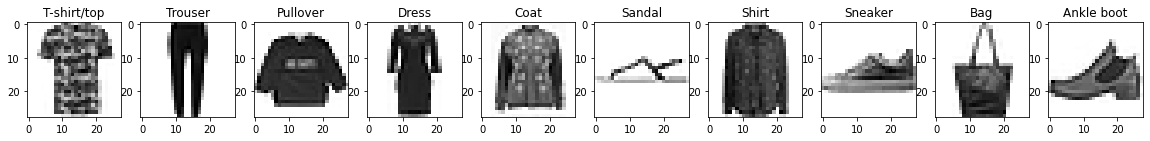

In [8]:
# Выделим по одному изображению каждого класса
one_category = df_train.groupby('label').head(1)
one_category = one_category.set_index('label')

# Вывод на экран изображений
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,7))

n = 0
for ax in axes.flat:
    ax.set(title=(class_names[n]))
    image = one_category.loc[n,:].values.reshape(28, 28, 1)
    ax.imshow(image, cmap=plt.cm.binary)
    n += 1
plt.show()

**Вывод**

1. Набор данных содержит 60000 изображений в тренировочном наборе и 10000 изображений в тестовом наборе данных. Такого количества должно быть достаточно для обучения модели.
2. Вещи предствалены 10 классов, причём их количество по классам одинаково. Таким образом, дизбаланса классов не наблюдается.
3. Изображеняи имеют размер 28Х28 пиксклей и один канал цвета. В датасети они представлены в виде списка, поэтому на этапе предобработки, их необходимо привести в двумерный вид.
4. Изображения предобработаны, и не требуют дальнейшего преобразования.
5. В тренировочном наборе данных присутствует 43 дубликата. В целом, такое небольшое количество повторяющехся изображений не должно сильно сказаться на качестве обучения модели, думаю лучше будет от них избавится.


## Подготовка данных и обучение модели

1. Избавимся от дубликатов.
2. Создадим функции `load_train` и `load_test` по подготовке данных тренировочного и тестового набора данных. В них произведём преобразование данных из одномерного списка в двумерное изображение и нормализуем их.
3. Создадим функцию `create_model_LeNet`, которая будет создавать и компилировать модель. Применим нейросетевую модель с архитектурой LeNet. Оптимизатор и его параметры выберем опытным путём.
4. Создадим функцию `train_model`, которая будет отвечать за обучение модели.
5. Обучим модель.

In [9]:
# Удалим дубликаты
df_train = df_train.drop_duplicates()

In [10]:
def load_train(df_train):
    """ Принимаем датафрейм с тренировочными данными.
        Возвращаем преобразованные и нормализованные признаки и целевой признак
    """
    features_train = df_train.drop('label', axis=1).values
    target_train = df_train['label']
    features_train = features_train.reshape(-1, 28, 28, 1) / 255.0
    return features_train, target_train

In [11]:
def load_test(df_test):
    """ Принимаем датафрейм с тестовыми данными.
        Возвращаем преобразованные и нормализованные признаки и целевой признак
    """
    features_test = df_test.drop('label', axis=1).values
    target_test = df_test['label']
    features_test = features_test.reshape(-1, 28, 28, 1) / 255.0
    return features_test, target_test

In [12]:
def create_model(input_shape, optimizer=Adam(learning_rate=0.001)):
    """ Принимаем размер входных данных и оптимизатор.
        Возвращаем созданную модель
    """
    model = Sequential()
    model.add(Conv2D(kernel_size=(5, 5), filters=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(kernel_size=(5, 5), filters=16, padding='valid', activation='relu', strides=1))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))
   
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    model.summary()
    
    return model


In [13]:
def train_model(model, train_data, test_data, batch_size=32, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    """ Принимаем модель, данные и параметры.
        Возвращаем обученную модель
    """
    features_train, target_train = train_data
    features_test, target_test = test_data
    model.fit(features_train, target_train, 
              validation_data=(features_test, target_test),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

In [14]:
# Обучение модели
model = train_model(create_model((28, 28, 1), optimizer=Adamax(learning_rate=0.007)), 
                    load_train(df_train),
                    load_test(df_test),
                    batch_size=64,
                    epochs=10,
                   )

2022-07-16 16:22:06.519077: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

2022-07-16 16:22:07.476465: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
937/937 - 8s - loss: 0.5360 - acc: 0.8023 - val_loss: 0.3999 - val_acc: 0.8502
Epoch 2/10
937/937 - 7s - loss: 0.3719 - acc: 0.8649 - val_loss: 0.3339 - val_acc: 0.8742
Epoch 3/10
937/937 - 8s - loss: 0.3222 - acc: 0.8814 - val_loss: 0.3004 - val_acc: 0.8867
Epoch 4/10
937/937 - 8s - loss: 0.2898 - acc: 0.8936 - val_loss: 0.3102 - val_acc: 0.8829
Epoch 5/10
937/937 - 7s - loss: 0.2672 - acc: 0.9012 - val_loss: 0.2759 - val_acc: 0.8954
Epoch 6/10
937/937 - 7s - loss: 0.2500 - acc: 0.9070 - val_loss: 0.2715 - val_acc: 0.8972
Epoch 7/10
937/937 - 7s - loss: 0.2352 - acc: 0.9128 - val_loss: 0.2513 - val_acc: 0.9094
Epoch 8/10
937/937 - 7s - loss: 0.2231 - acc: 0.9172 - val_loss: 0.2551 - val_acc: 0.9057
Epoch 9/10
937/937 - 8s - loss: 0.2091 - acc: 0.9218 - val_loss: 0.2624 - val_acc: 0.9050
Epoch 10/10
937/937 - 7s - loss: 0.1987 - acc: 0.9259 - val_loss: 0.2463 - val_acc: 0.9100


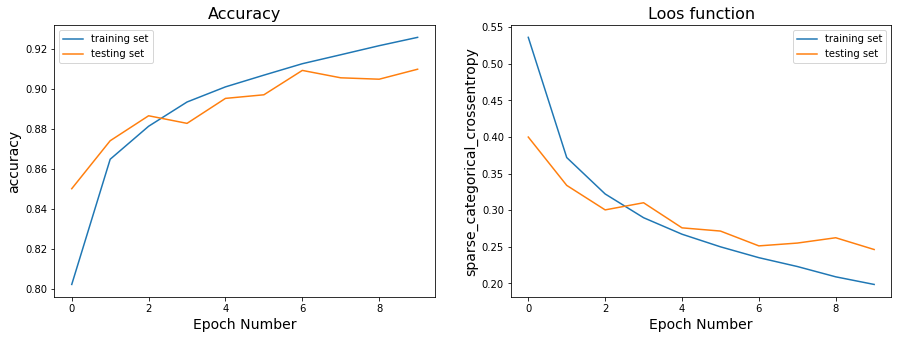

In [15]:
# Визуализация процесса обучения модели
fig = plt.figure(figsize=(15,5))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1.set_title('Accuracy', fontsize=16)
ax_1.set_xlabel('Epoch Number', fontsize=14)
ax_1.set_ylabel('accuracy', fontsize=14)
ax_1 = plt.plot(model.history.history['acc'], label='training set')
ax_1 = plt.plot(model.history.history['val_acc'], label='testing set')
plt.legend();

# 
ax_2 = fig.add_subplot(1, 2, 2)
ax_2.set_title('Loos function', fontsize=16)
ax_2.set_xlabel('Epoch Number', fontsize=14)
ax_2.set_ylabel('sparse_categorical_crossentropy', fontsize=14)
ax_2 = plt.plot(model.history.history['loss'], label='training set')
ax_2 = plt.plot(model.history.history['val_loss'], label='testing set')


plt.legend();

**Вывод**

Была поставлена задача классификации предметов гардероба по изображению.

Анализ данных выявил, что больших проблем, влияющих на возможность построения модели в наборе данных нет. Были удалены дубликаты, данные были приведены к двумерному виду и нормализованы.

Затем была создана модель на основе нейросетевой архитектуры LeNet, отличающейся от оригинальной тем, что активаторы были заменены на 'relu'. 

Модель показала точность классификации = 0.91.